# COVID-19 Global Data Tracker
This Jupyter Notebook analyzes global COVID‑19 data—including trends in cases, deaths, and vaccinations—using real‑world datasets from **Our World in Data**. You’ll find step‑by‑step sections that cover data collection, exploration, cleaning, EDA, visualizations, and a place for narrative insights.

> **Project objectives:** import & clean data · analyze trends · compare countries · visualize metrics · communicate findings.

## 1 · Data Collection
**Source:** [Our World in Data](https://ourworldindata.org/covid-cases) ‑ `owid‑covid‑data.csv`

Download the latest CSV and place it in the working directory.

In [4]:
# 1 · Data Collection — load raw CSV
import pandas as pd, warnings, os, sys
warnings.filterwarnings('ignore')

DATA_PATH = 'owid-covid-data.csv'

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"{DATA_PATH} not found. Download it from "
        "https://github.com/owid/covid-19-data/tree/master/public/data and place it next to this notebook."
    )

df = pd.read_csv(DATA_PATH)
print(f"Raw shape: {df.shape}")
print("Sample rows:"); display(df.head())

Raw shape: (429435, 67)
Sample rows:


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


## 2 · Data Loading & Exploration

In [5]:
# Inspect columns & missing values
print("Columns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(15))

Columns: ['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred'

## 3 · Data Cleaning

In [6]:
# Convert date column & select relevant countries
import numpy as np
df['date'] = pd.to_datetime(df['date'], errors='coerce')
default_countries = ['Kenya','United States','India','Germany','Brazil','South Africa','Australia','United Kingdom','China']
existing_countries = [c for c in default_countries if c in df['location'].unique()]
df = df[df['location'].isin(existing_countries)].copy()

# Basic cleanup
numeric_cols = ['total_cases','total_deaths','new_cases','new_deaths','total_vaccinations']
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(method='ffill')

df = df.dropna(subset=['date','total_cases','total_deaths'])
print("Cleaned shape:", df.shape)

Cleaned shape: (15074, 67)


## 4 · Exploratory Data Analysis (EDA) — Cases & Deaths

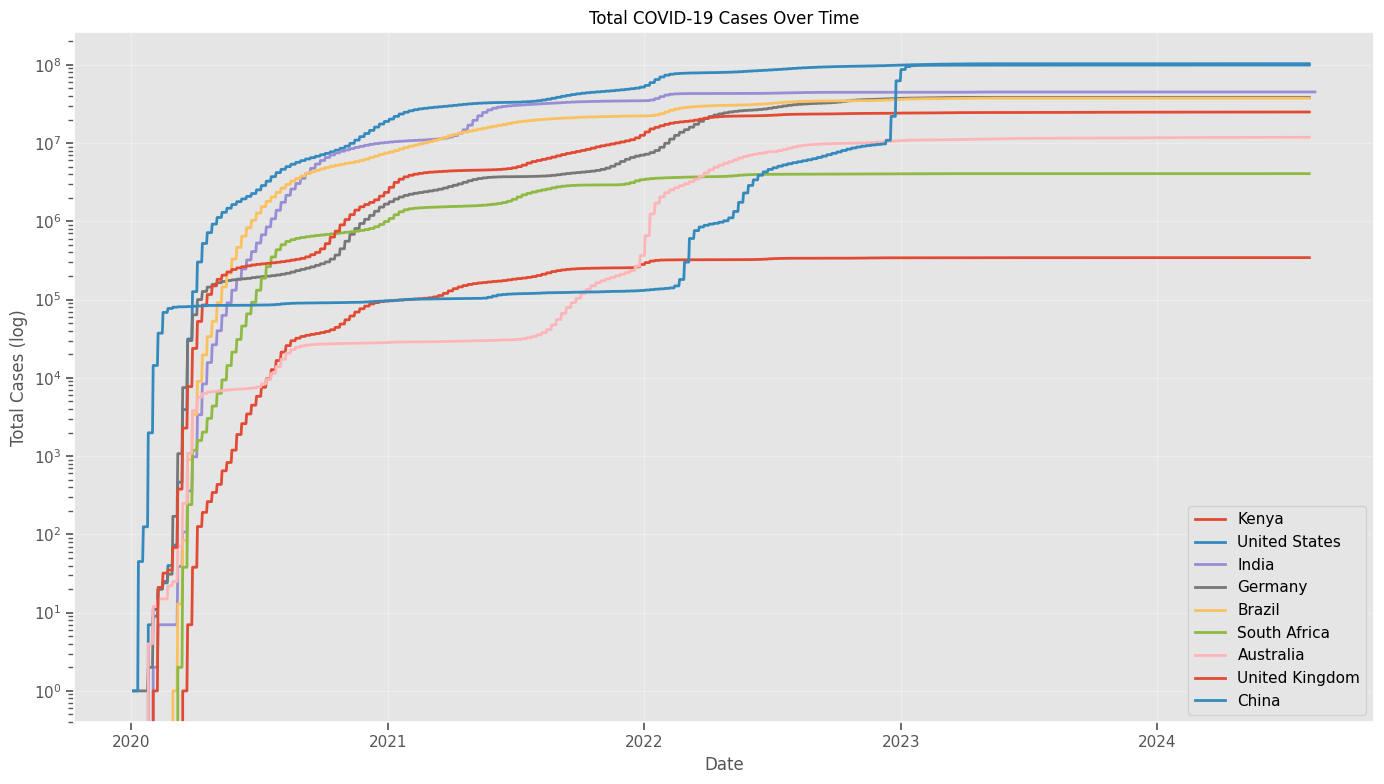

In [9]:
import matplotlib.pyplot as plt, seaborn as sns
plt.style.use('ggplot'); sns.set_context('notebook')

# Total cases over time (log‑scale)
plt.figure(figsize=(14,8))
for c in existing_countries:
    subset = df[df['location']==c]
    plt.plot(subset['date'], subset['total_cases'], label=c, linewidth=2)
plt.yscale('log'); plt.grid(alpha=.3)
plt.title('Total COVID‑19 Cases Over Time'); plt.xlabel('Date'); plt.ylabel('Total Cases (log)')
plt.legend(); plt.tight_layout(); plt.show()

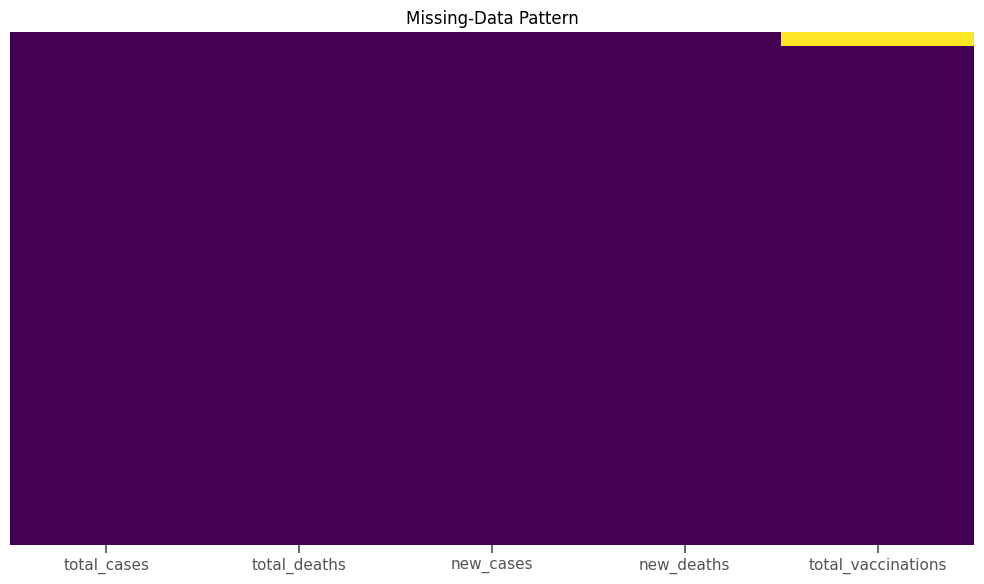

In [10]:
# Heatmap of missing data for key columns
import seaborn as sns, matplotlib.pyplot as plt
key_cols = ['total_cases','total_deaths','new_cases','new_deaths','total_vaccinations']
plt.figure(figsize=(10,6))
sns.heatmap(df[key_cols].isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing‑Data Pattern'); plt.tight_layout(); plt.show()

## 5 · Vaccination Progress

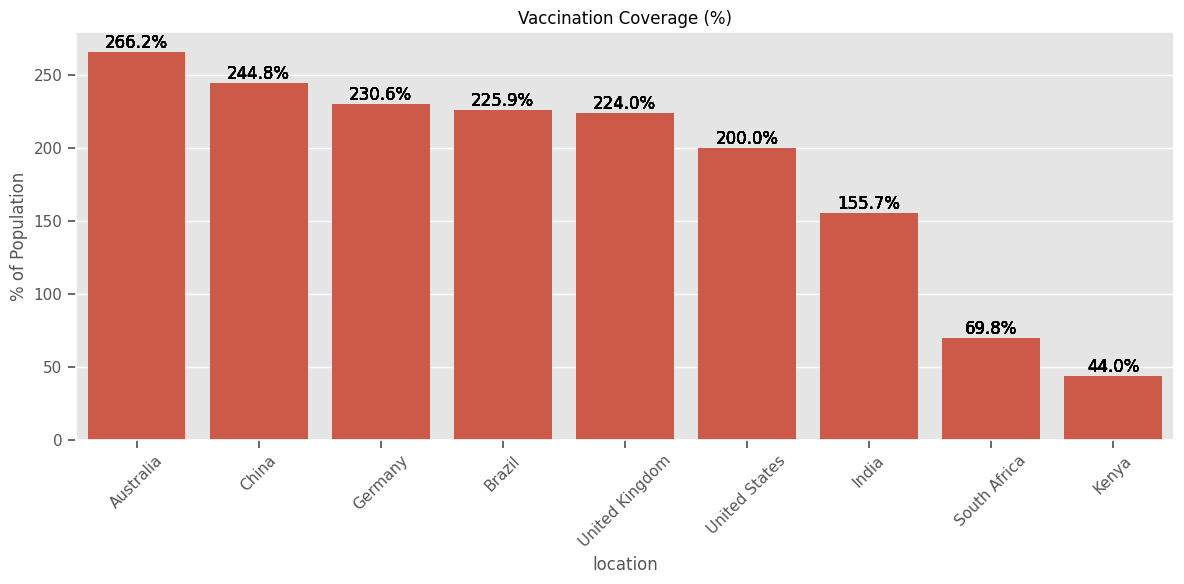

In [11]:
# Vaccination rate (%) for latest date
latest = df.sort_values('date').groupby('location').last().reset_index()
if {'total_vaccinations','population'}.issubset(latest.columns):
    latest['vax_rate'] = 100*latest['total_vaccinations']/latest['population']
    latest = latest.sort_values('vax_rate', ascending=False)

    plt.figure(figsize=(12,6))
    bars = sns.barplot(data=latest, x='location', y='vax_rate')
    plt.xticks(rotation=45); plt.title('Vaccination Coverage (%)'); plt.ylabel('% of Population')
    for bar in bars.containers[0]:
        bars.bar_label(bars.containers[0], fmt='%.1f%%', label_type='edge')
    plt.tight_layout(); plt.show()

## 6 · Death‑Rate Analysis

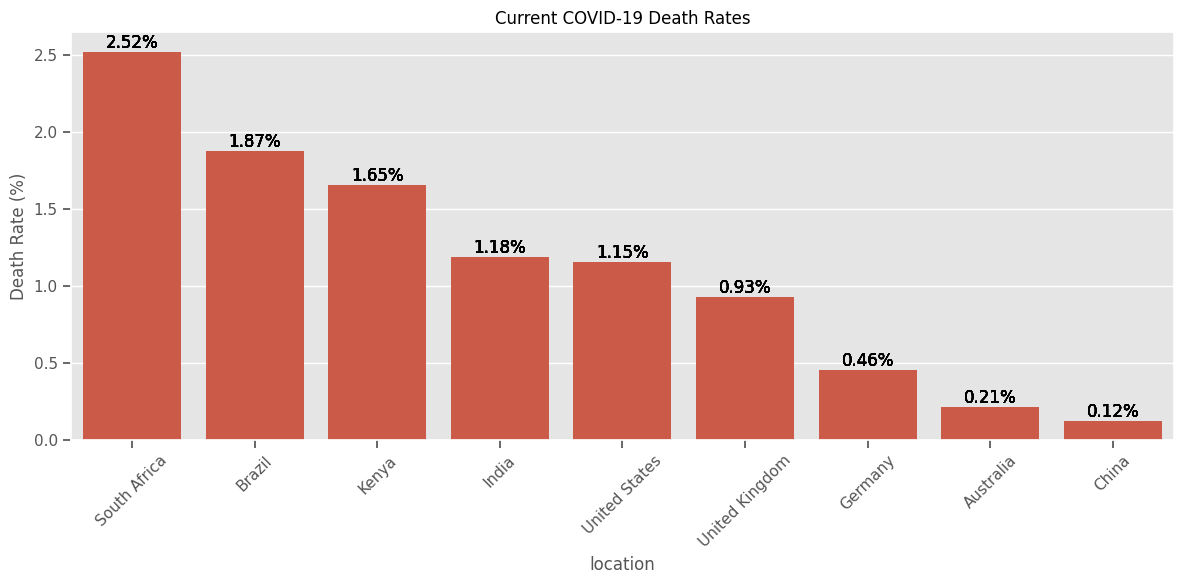

In [12]:
df['death_rate'] = 100*df['total_deaths']/df['total_cases']
latest = df.sort_values('date').groupby('location').last().reset_index().sort_values('death_rate', ascending=False)

plt.figure(figsize=(12,6))
bars = sns.barplot(data=latest, x='location', y='death_rate')
plt.xticks(rotation=45); plt.ylabel('Death Rate (%)'); plt.title('Current COVID‑19 Death Rates')
for bar in bars.containers[0]:
    bars.bar_label(bars.containers[0], fmt='%.2f%%', label_type='edge')
plt.tight_layout(); plt.show()

## 7 · 7‑Day Rolling Average of New Cases

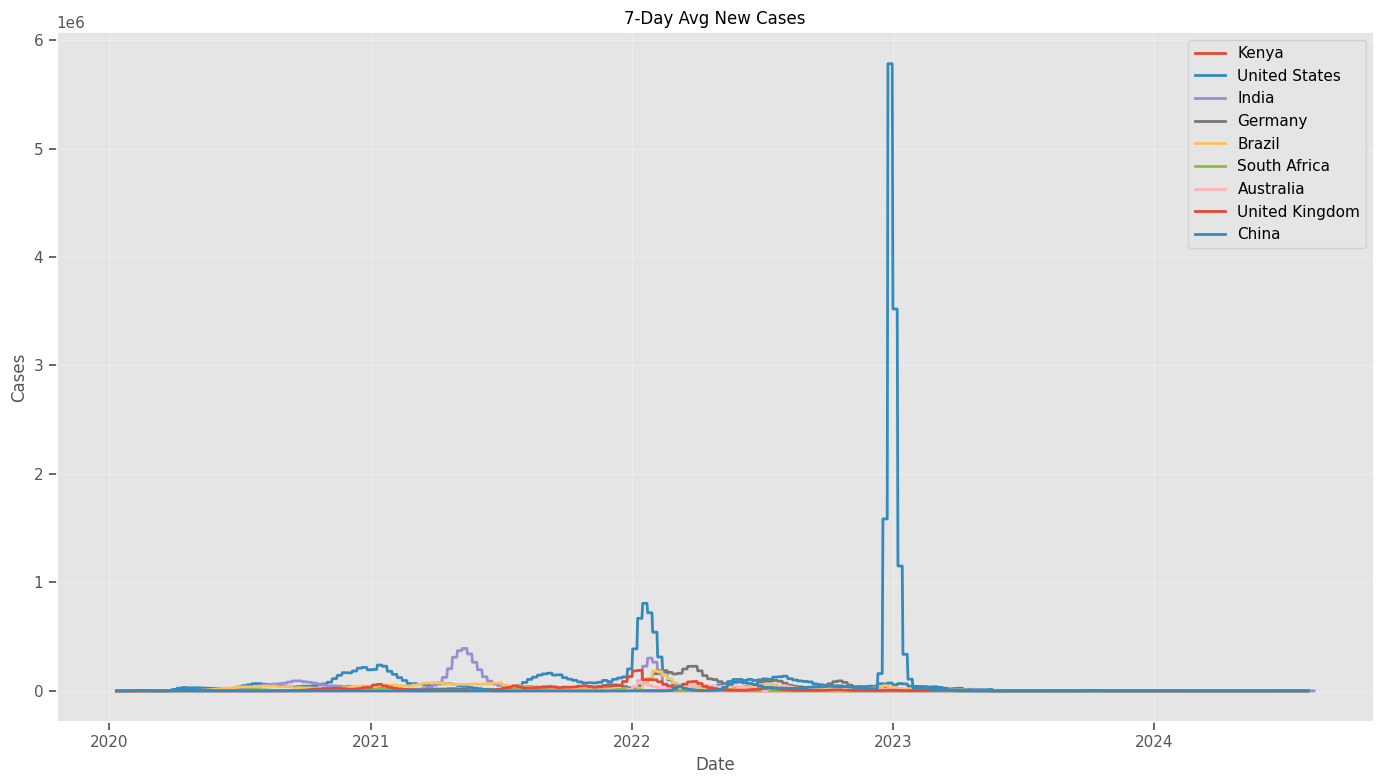

In [13]:
plt.figure(figsize=(14,8))
for c in existing_countries:
    subset = df[df['location']==c].copy()
    subset['rolling'] = subset['new_cases'].rolling(window=7).mean()
    plt.plot(subset['date'], subset['rolling'], label=c, linewidth=2)
plt.grid(alpha=.3); plt.title('7‑Day Avg New Cases'); plt.xlabel('Date'); plt.ylabel('Cases')
plt.legend(); plt.tight_layout(); plt.show()

## 9 · Summary Statistics

In [14]:
latest = df.sort_values('date').groupby('location').last().reset_index()
print("As of", latest['date'].max().strftime('%Y‑%m‑%d'))
display(latest[['location','total_cases','total_deaths','death_rate']].sort_values('total_cases', ascending=False))

As of 2024-08-12


,location,total_cases,total_deaths,death_rate
8,United States,103436829.0,1193165.0,1.153520
2,China,99373219.0,122304.0,0.123075
4,India,45041748.0,533623.0,1.184730
3,Germany,38437756.0,174979.0,0.455227
1,Brazil,37511921.0,702116.0,1.871714
7,United Kingdom,24974629.0,232112.0,0.929391
0,Australia,11861161.0,25236.0,0.212762
6,South Africa,4072765.0,102595.0,2.519050
5,Kenya,344106.0,5689.0,1.653270


## 10 · Insights & Conclusions
Use this markdown cell to record **3‑5 narrative insights**. Example:
- Country X achieved the fastest vaccination rollout (>70% by mid‑2021).
- Death rates remain highest in Country Y despite lower case counts, suggesting differences in healthcare capacity.
- A global decline in new cases is visible after widespread vaccine availability in late‑2021.

Feel free to expand this discussion and add policy implications or future‑work ideas.

In [15]:
# Export cleaned subset
CLEAN_PATH = 'cleaned_covid_data.csv'
df.to_csv(CLEAN_PATH, index=False)
print(f"Cleaned data saved → {CLEAN_PATH}")

Cleaned data saved → cleaned_covid_data.csv
